In [3]:
#https://www.kaggle.com/gpreda/santander-eda-and-predictionimport 
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
PATH="/home/david/Documentos/santander-customer-transaction-prediction/"
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

In [10]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [11]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [12]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [14]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))


In [15]:
%%time
missing_data(train_df)

CPU times: user 3.42 s, sys: 304 ms, total: 3.72 s
Wall time: 4.89 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [16]:
train_df.describe()


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [17]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


<Figure size 432x288 with 0 Axes>

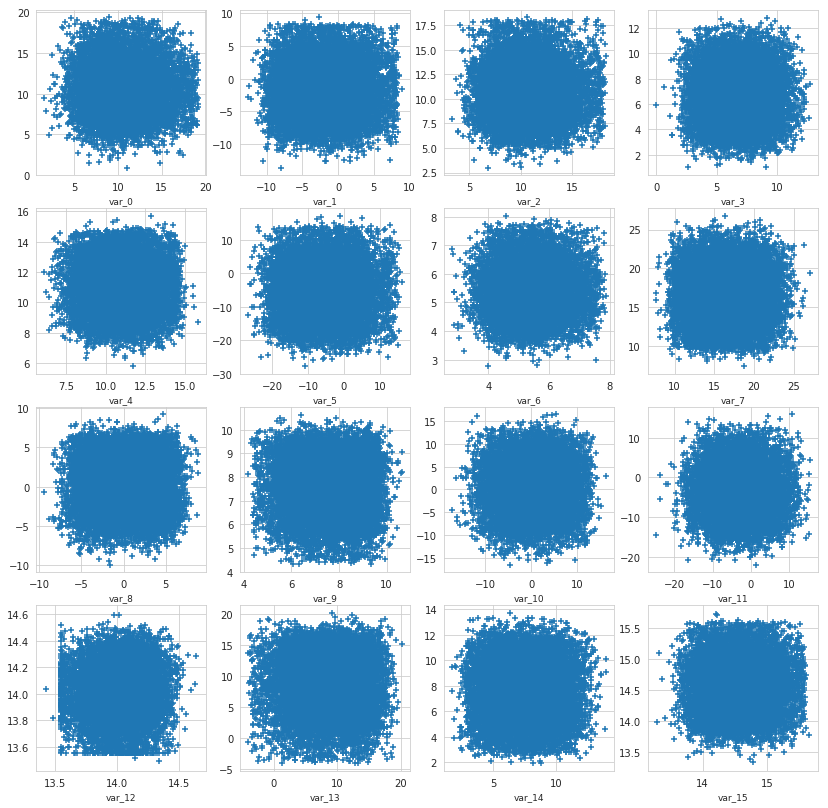

In [20]:

def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

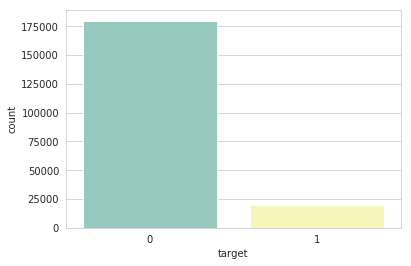

In [21]:
sns.countplot(train_df['target'], palette='Set3')

In [22]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


In [23]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

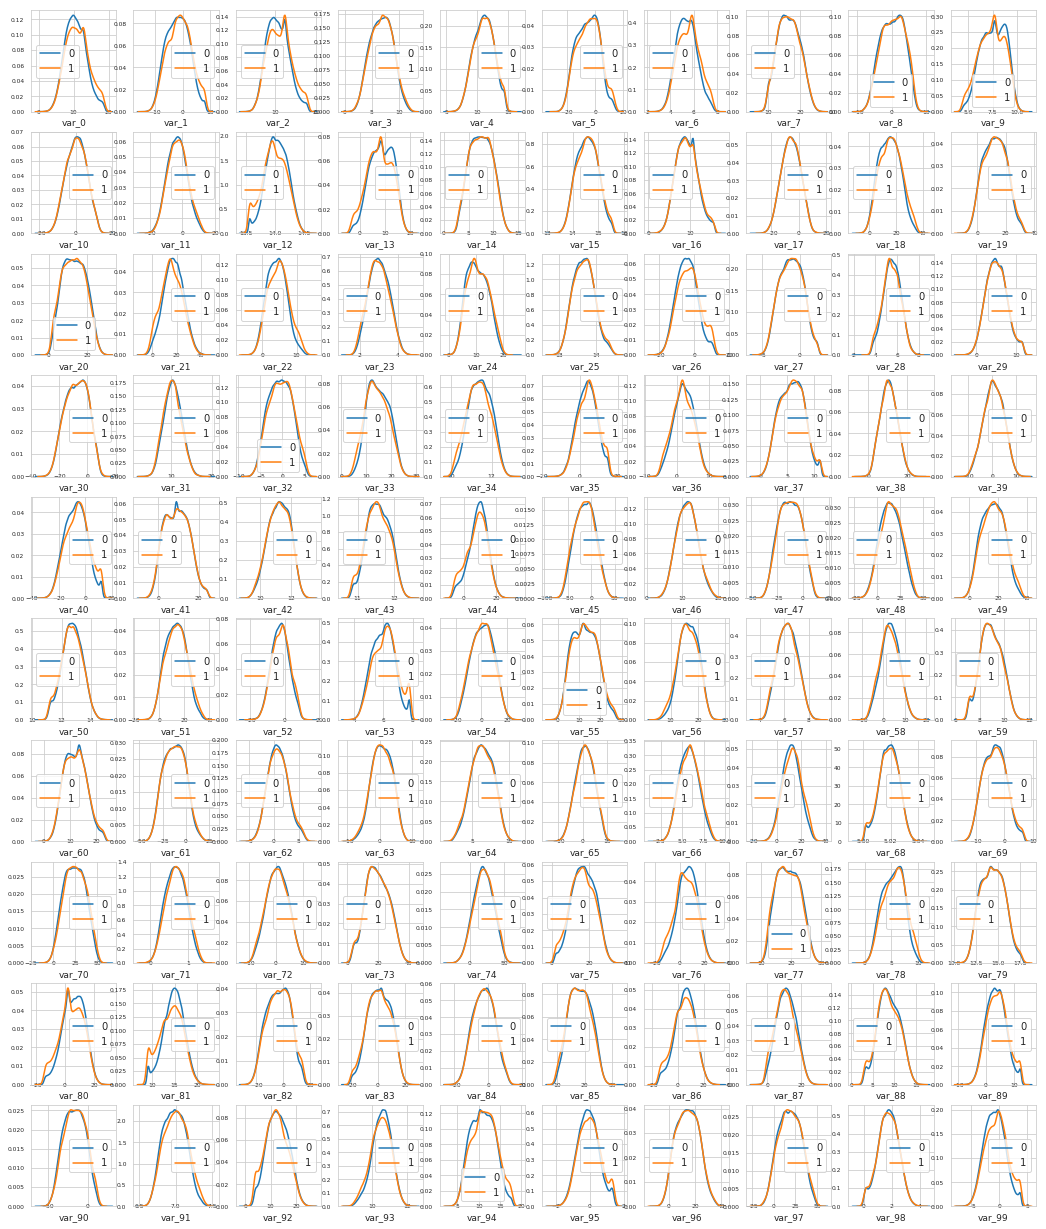

In [24]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

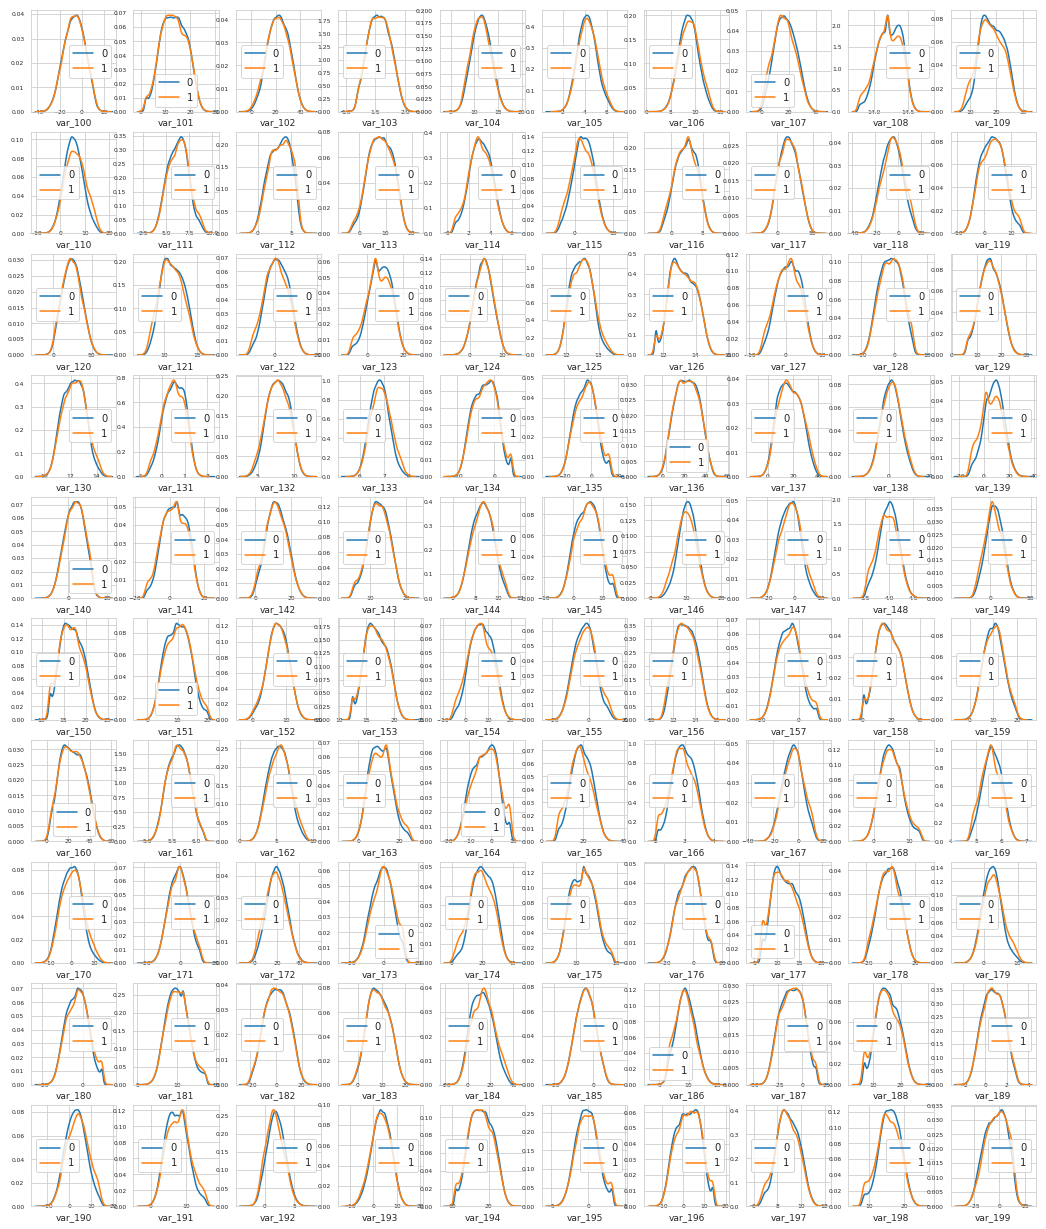

In [25]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

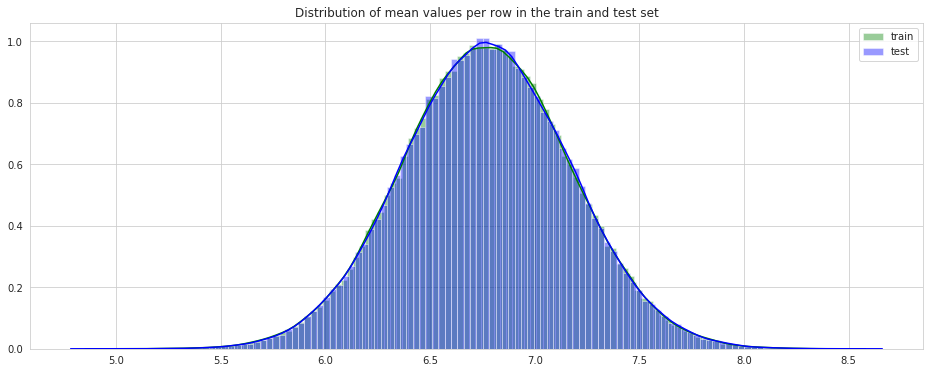

In [26]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [33]:
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]


In [34]:
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


In [35]:
correlations.tail(10)


,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


In [36]:
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [37]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [3]:
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [4]:
train_df[train_df.columns[202:]].head()


,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [5]:
test_df[test_df.columns[201:]].head()


,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [ ]:
train_df.to_csv(PATH+"trainnewfeat.csv")
test_df.to_csv(PATH+"testnewfeat.csv")

In [6]:
PATH="/home/microp/Escritorio/santander-customer-transaction-prediction/"
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")


In [7]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 202 201


In [15]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [9]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

Read the lgb documentation https://lightgbm.readthedocs.io/en/latest/

In [10]:


folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.89904	valid_1's auc: 0.880364
[2000]	training's auc: 0.911204	valid_1's auc: 0.888868
[3000]	training's auc: 0.91903	valid_1's auc: 0.893151
[4000]	training's auc: 0.924854	valid_1's auc: 0.896012
[5000]	training's auc: 0.929701	valid_1's auc: 0.897714
[6000]	training's auc: 0.933934	valid_1's auc: 0.898494
[7000]	training's auc: 0.93786	valid_1's auc: 0.898994
[8000]	training's auc: 0.941613	valid_1's auc: 0.89928
[9000]	training's auc: 0.945152	valid_1's auc: 0.899671
[10000]	training's auc: 0.948466	valid_1's auc: 0.899878
[11000]	training's auc: 0.951758	valid_1's auc: 0.900177
[12000]	training's auc: 0.954863	valid_1's auc: 0.899992
[13000]	training's auc: 0.957793	valid_1's auc: 0.899881
[14000]	training's auc: 0.96065	valid_1's auc: 0.899628
Early stopping, best iteration is:
[11045]	training's auc: 0.951908	valid_1's auc: 0.900223
Fold 1
Training until validation scores don't improve 

[11000]	training's auc: 0.951843	valid_1's auc: 0.900587
[12000]	training's auc: 0.954894	valid_1's auc: 0.900639
Early stopping, best iteration is:
[9691]	training's auc: 0.947612	valid_1's auc: 0.900898
CV score: 0.90053 


https://www.datacamp.com/community/tutorials/xgboost-in-python

If you plan to use XGBoost on a dataset which has categorical features you may want to consider applying some encoding (like one-hot encoding) to such features before training the model. Also, if you have some missing values such as NA in the dataset you may or may not do a separate treatment for them, because XGBoost is capable of handling missing values internally. You can check out this link if you wish to know more on this.

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [19]:
X, y = train_df.iloc[:,2:], target

In [22]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [25]:
xgb = XGBClassifier(n_estimators=100)

In [27]:
import time
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 89.89
Time consumed for training: 154.499
Time consumed for prediction: 0.20852 seconds


In [28]:
acc_xgb

89.895